In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Prepare training data
if "dataset" not in globals():
    loaded_data = torch.load('data/data_tensors.pt')
    dataset = TensorDataset(loaded_data)

0 torch.Size([3, 320, 240])
1 torch.Size([3, 320, 240])
2 torch.Size([3, 320, 240])
3 torch.Size([3, 320, 240])


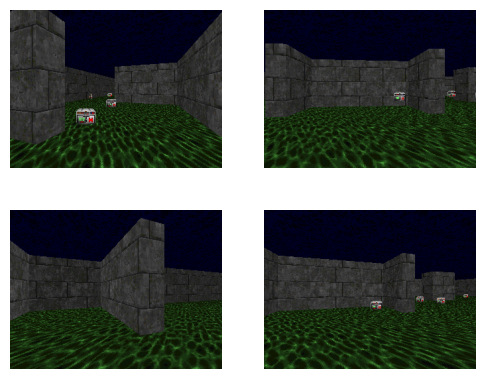

In [3]:
import matplotlib.pyplot as plt

def plot_tensor_image(imgs):
    plt.figure(figsize=(6, 10))
    for i, img in enumerate(imgs):
        print(i, img.shape)
        img = img.permute(2, 1, 0).detach()
        # Display the image
        plt.subplot(4, 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

for batch, in DataLoader(dataset, batch_size=4, shuffle=True):
    plot_tensor_image(batch)
    break

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        
        self.enc_mid = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1),
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 4, 2, 1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 4, 2, 1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1), 
        )
        self.enc_end = nn.Sequential(
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),
        )
        
        self.dec_mid = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),
        )
        self.dec_end = nn.Sigmoid()

    def encode(self, x):
        z = self.enc_mid(x)
        z = self.enc_end(z)
        mu, logvar = torch.chunk(z, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.dec_mid(z)
        x_recon = self.dec_end(x)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(x, x_recon, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, kl_loss

In [6]:
from torch import optim
from torchinfo import summary

gpu = torch.device('cuda')
ae = ConvVAE().to(gpu)
optimizer = optim.Adam(ae.parameters(), lr=5e-4)

summary(ae, input_size=(512, 3, 320, 240))

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [512, 3, 320, 240]        --
├─Sequential: 1-1                        [512, 32, 20, 15]         --
│    └─Conv2d: 2-1                       [512, 16, 160, 120]       784
│    └─BatchNorm2d: 2-2                  [512, 16, 160, 120]       32
│    └─ReLU: 2-3                         [512, 16, 160, 120]       --
│    └─Conv2d: 2-4                       [512, 16, 80, 60]         4,112
│    └─BatchNorm2d: 2-5                  [512, 16, 80, 60]         32
│    └─ReLU: 2-6                         [512, 16, 80, 60]         --
│    └─Conv2d: 2-7                       [512, 16, 40, 30]         4,112
│    └─BatchNorm2d: 2-8                  [512, 16, 40, 30]         32
│    └─ReLU: 2-9                         [512, 16, 40, 30]         --
│    └─Conv2d: 2-10                      [512, 32, 20, 15]         8,224
├─Sequential: 1-2                        [512, 32, 20, 15]         --
│    

In [7]:
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
print("Total samples in dataset:", len(dataloader.dataset))
print("Number of batches per epoch:", len(dataloader))
print("Size of each batch:", dataloader.batch_size)

Total samples in dataset: 20000
Number of batches per epoch: 40
Size of each batch: 512


In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss_1, running_loss_2, running_loss_3 = 0. , 0., 0.
    for batch_idx, (data_batch,) in enumerate(dataloader):
        x = data_batch.to(gpu)
        optimizer.zero_grad()
        predicted_x, mu, logvar = ae(x)
        recon_loss, kl_loss = vae_loss(x, predicted_x, mu, logvar)
        loss = recon_loss + .001 * kl_loss
        loss.backward()
        optimizer.step()
        running_loss_1 += recon_loss.item()
        running_loss_2 += kl_loss.item()
        running_loss_3 += loss.item()
    print(f"Epoch: {epoch}/{num_epochs}, Loss: {running_loss_1:.2f} and {.001 * running_loss_2:.2f} => {running_loss_3:.2f}")

checkpoint = {
    'model_state_dict': ae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, 'checkpoint/autoencoder_checkpoint.pth')
print('Checkpoint saved')


Epoch: 0/100, Loss: 482807712.94 and 2205607.16 => 485013319.00
Epoch: 1/100, Loss: 159304552.75 and 50340.87 => 159354893.92
Epoch: 2/100, Loss: 65162794.14 and 51910.30 => 65214704.62
Epoch: 3/100, Loss: 38644078.62 and 52930.81 => 38697009.40
Epoch: 4/100, Loss: 28859346.00 and 53913.97 => 28913259.88
Epoch: 5/100, Loss: 24270033.30 and 55056.59 => 24325090.03
Epoch: 6/100, Loss: 21697967.82 and 56460.16 => 21754427.82
Epoch: 7/100, Loss: 20049375.66 and 57974.63 => 20107350.29
Epoch: 8/100, Loss: 18881384.28 and 59499.51 => 18940883.72
Epoch: 9/100, Loss: 17978642.85 and 61005.00 => 18039647.78
Epoch: 10/100, Loss: 17237789.43 and 62516.14 => 17300305.65
Epoch: 11/100, Loss: 16592551.82 and 64035.12 => 16656586.97
Epoch: 12/100, Loss: 16081105.46 and 65554.27 => 16146659.78
Epoch: 13/100, Loss: 15656234.42 and 67104.93 => 15723339.30
Epoch: 14/100, Loss: 15285246.71 and 68669.05 => 15353915.70
Epoch: 15/100, Loss: 14954849.25 and 70263.02 => 15025112.33
Epoch: 16/100, Loss: 1465511

torch.Size([8, 3, 320, 240])
0 torch.Size([3, 320, 240])
1 torch.Size([3, 320, 240])
2 torch.Size([3, 320, 240])
3 torch.Size([3, 320, 240])
4 torch.Size([3, 320, 240])
5 torch.Size([3, 320, 240])
6 torch.Size([3, 320, 240])
7 torch.Size([3, 320, 240])


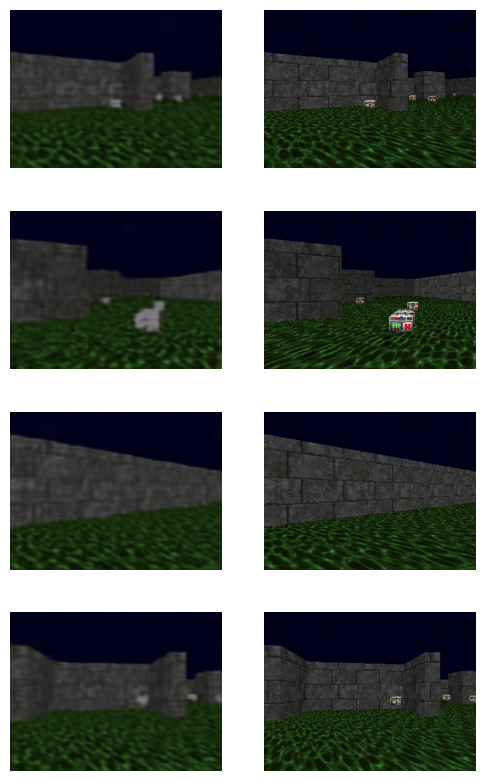

In [9]:
cpu = torch.device('cpu')

for batch, in DataLoader(dataset, batch_size=4, shuffle=True):
    x = batch.to(gpu)
    predicted_x, mu, logvar = ae(x) 

    b, c, h, w = predicted_x.shape
    # interleave trick
    x = torch.stack((predicted_x, x[:, :, :h, :w]), dim=1).view(-1, c, h , w)
    print(x.shape)
    plot_tensor_image(x.to(cpu))
    break